<a href="https://colab.research.google.com/github/gauriverma19/NYC_AIRBNB_PRICE_PREDICTION/blob/master/airbnb_nyc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Rental Price Prediction of Airbnb In New York City

Author: Gauri Verma

Abstract : This project focuses on predicting prices for airbnb in NYC. I consider it as a supervised regression problem.My approach is touse Linear and Ridge Regression, Random Forest, Linear SVR and KNN. Despite all the advantages and disadvantages of each approach, the results showed that Random Forest had the best performance for this problem. For inspiration of future predicting models, ensemble methods and deep learning may improve our model more.

1. Introduction and Motivation:

Airbnb is a platform where millions of hosts and travelers list their space and book unique accommodations anywhere in the world. Airbnb affects the city's housing supply and affordability. In a modern, busy cosmopolitan like NYC, there are so many competitions for housing and huge demands for accommodations, Airbnb pricing is important to get right. If the price is too high the hosts might risk losing customers while if the price is too low they might be missing out on potential benefits. The goal of our project is to come up with the appropriate prediction of Airbnb price using machine learning, so the hosts can achieve optimal profits. One of the challenges we faced is that since the raw data we used consists of both categorical and numerical values and missing values which makes classification difficult

2. Description of Dataset

The data was downloaded from Kaggle 'https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data' . Inside Airbnb is an independent, non-commercial organization that provides Airbnb data in cities around the world. Specifically, this dataset describes the listing activity and metrics in NYC, NY in 2019. The columns include the following information: id number of the housing, name of the host, id number of the host, the neighbourhood group that the housing is located (Queens, Brookly, Manhattan,Bronx and Staten Island), the specific neighbourhood, latitude and longitude, type of room, price per night, the minimum nights allowed to book, the number of reviews, the date of last review, average reviews per month, the number of host listings, and the available days in 365 days.

In [2]:
#importing the necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

#Model interpretation modules
#import eli5
#import lime
#import lime.lime_tabular
#import shap
#shap.initjs()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [5]:
#pip install lime

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cd Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [9]:
#reading the data from the csv file

data = pd.read_csv('AB_NYC_2019.csv/AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [10]:
#number of rows(examples) and columns(features)

print('Number of features: {}'.format(data.shape[1]))
print('Number of examples: {}'.format(data.shape[0]))

Number of features: 16
Number of examples: 48895


In [11]:
#understanding the data types
data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

* The type int64 tells us that Python is storing each value within this column as a 64 bit integer.

* The type float64 tells us that Python is storing each value within this column as a 64 bit floating point number.

* An object is a string in pandas so it performs a string operation instead of a mathematical one.You can assign any reference type (string, array, class, or interface) to an Object variable.


In [12]:
#coverting last review data type to datetime format
data['last_review'] = pd.to_datetime(data['last_review'],infer_datetime_format=True) 

## **Preprocessing and** **EDA**

1. Handling missing data

In [13]:
#understanding the number and percent of null values in the data 

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum())/data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
reviews_per_month,10052,0.205583
last_review,10052,0.205583
host_name,21,0.000429
name,16,0.000327
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000
number_of_reviews,0,0.000000
minimum_nights,0,0.000000
price,0,0.000000
room_type,0,0.000000


In [14]:
#dropping host_name and name as they dont contribute to the price prediction

data.drop(['host_name','name'], axis=1, inplace=True)

In [15]:
#viewing 0's in number of reviews
data[data['number_of_reviews']== 0.0].shape

(10052, 14)

The NaN values in the last_review and reviews_per_month columns all occur for examples where no reviews were given.

For reviews_per_month, I will fill those values with 0's.

In [16]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [17]:
#converting the date of review to the number of days from the last review

earliest = min(data['last_review'])
data['last_review'] = data['last_review'].fillna(earliest)
data['last_review'] = data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [18]:
#checking for no null values 

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum())/data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
last_review,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0
room_type,0,0.0
longitude,0,0.0
latitude,0,0.0


2. Price Distribution

We can notice that the target has a highly skewed distribution. This can cause problems for machine learning algorithms such as linear regression. A log transformation and removal of outliers makes the distribution look much closer to normal.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


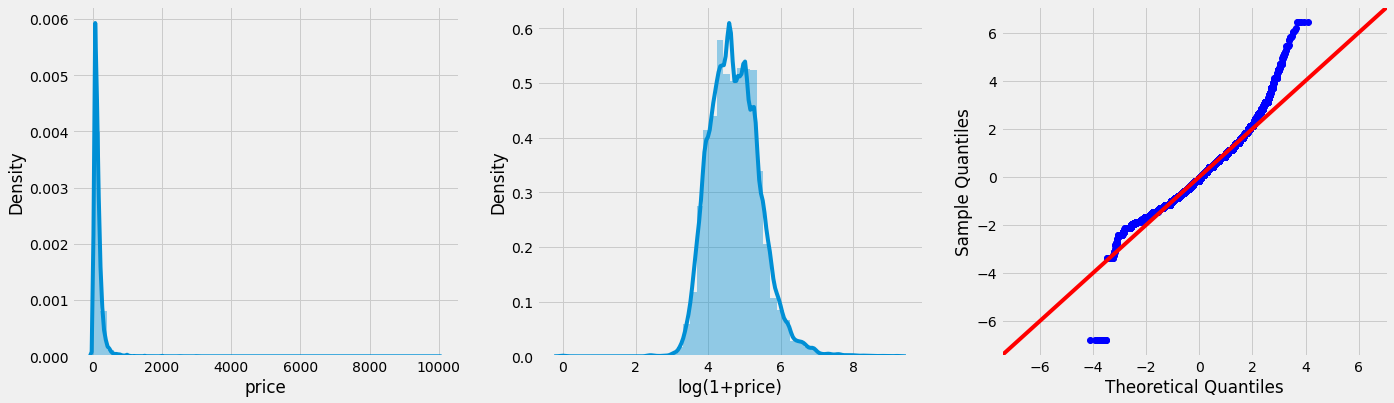

In [19]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [20]:
#fitting the log transformation in the limits from the above graph

data = data[np.log1p(data['price']) < 8]
data = data[np.log1p(data['price']) > 3]

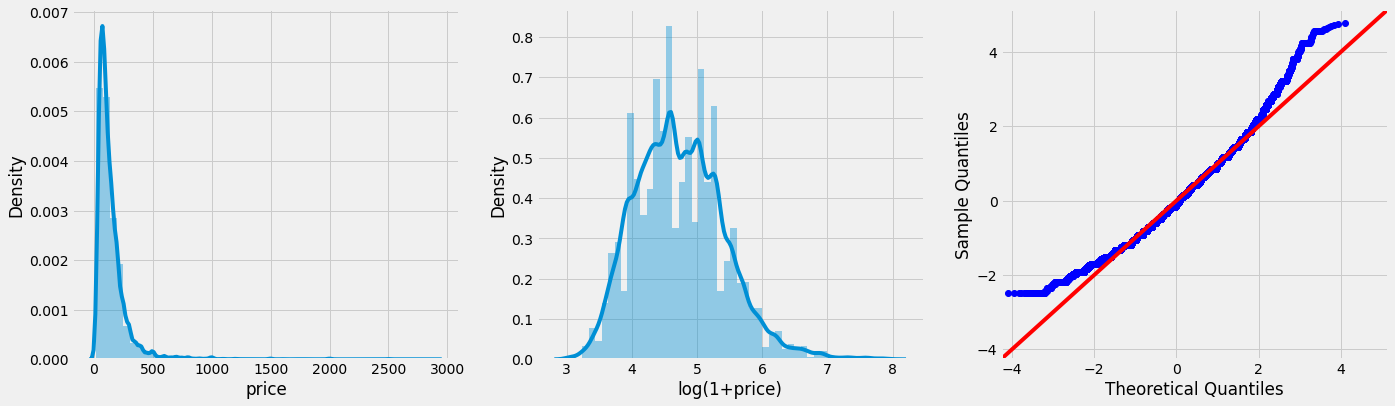

In [21]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [22]:
#converting price to its log transformation
data['price'] = np.log1p(data['price'])

In [23]:
#list of variables

print(data.columns)

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


In [24]:
#number of hosts vs number of properties
print('In this dataset there are {} unique hosts renting out  a total number of {} properties.'.format(len(data['host_id'].unique()), data.shape[0]))

In this dataset there are 37384 unique hosts renting out  a total number of 48784 properties.


In [25]:
#dropping unneccessary columns

data = data.drop(['host_id', 'id'], axis=1)

3. Neighborhood Group Analysis

I notice that Statten Island and the Bronx are highly underrepresented in this dataset. For Statten Island, the reason is that the population of the island is small. However, this cannot be the case for Bronx which has a population comparable (~ 1.4mln) to Manhattan (~ 1.6mln) or for for Brooklyn /Queens with their populations of ~2.5mln and ~2.4mln, respectively. 

This makes sense: Queens, Bronx  and, to a fair extent Brooklyn, are residential neighborhoods unlike Manhattan which is a business centre as well as a tourist destination.

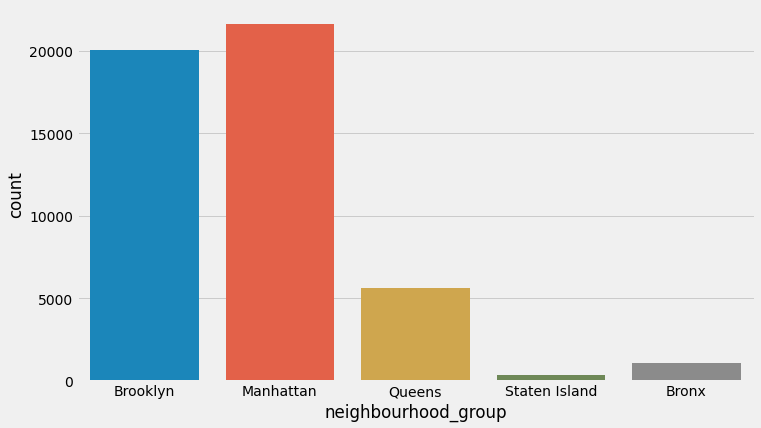

In [26]:
sns.catplot(x='neighbourhood_group', kind='count' ,data=data)
fig = plt.gcf()
fig.set_size_inches(12, 6)

4. Longitude and Latitude

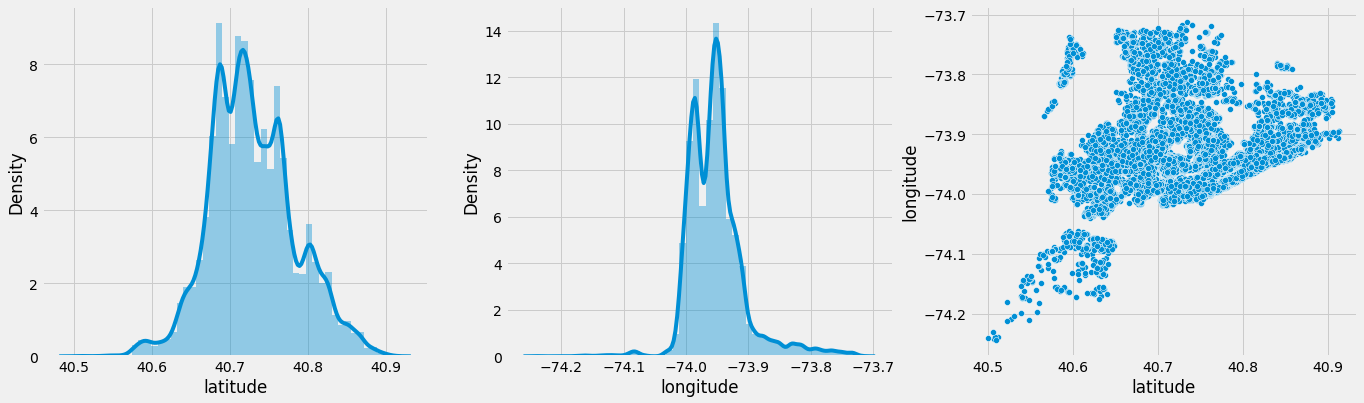

In [27]:
#density plots for longitude and latitude

fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['latitude'], ax=axes[0])
sns.distplot(data['longitude'], ax=axes[1])
sns.scatterplot(x= data['latitude'], y=data['longitude'])

5. Room Type


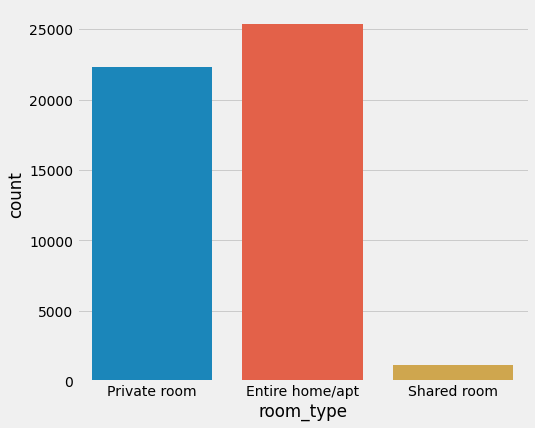

In [28]:
sns.catplot(x='room_type', kind='count' ,data=data)
fig = plt.gcf()
fig.set_size_inches(8, 6)

We can see that maximum airbns are of apartment type, followed by private rooms , and shared rooms with the least count.

6. Minimum Nights

Text(0, 0.5, 'count')

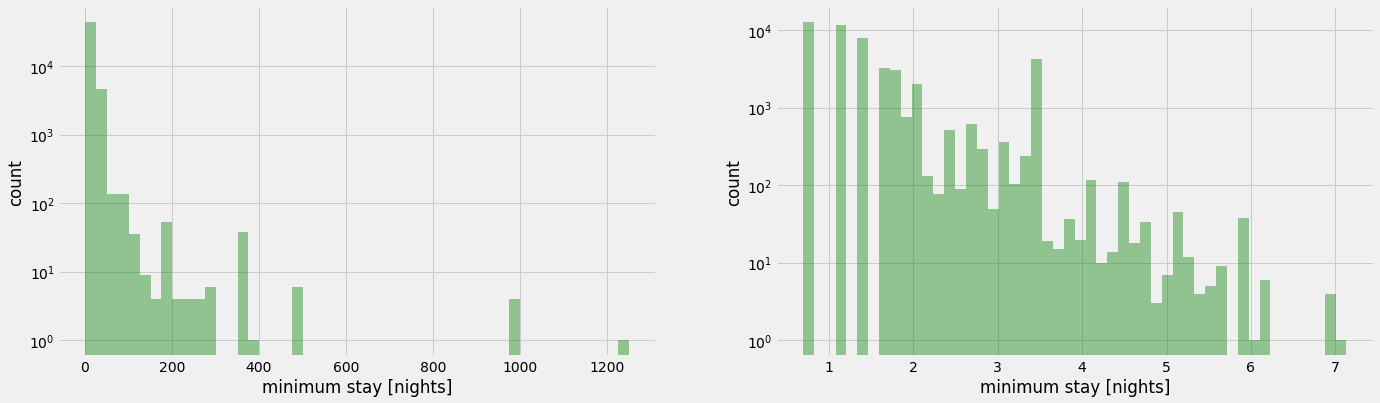

In [29]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(data['minimum_nights'], rug=False, kde=False, color="green", ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(data['minimum_nights']), rug=False, kde=False, color="green", ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')

In [30]:
#log transformation of the min nights to remove skewness

data['minimum_nights'] = np.log1p(data['minimum_nights'])

7. Reviews per month

Text(0.5, 0, 'ln(reviews_per_month)')

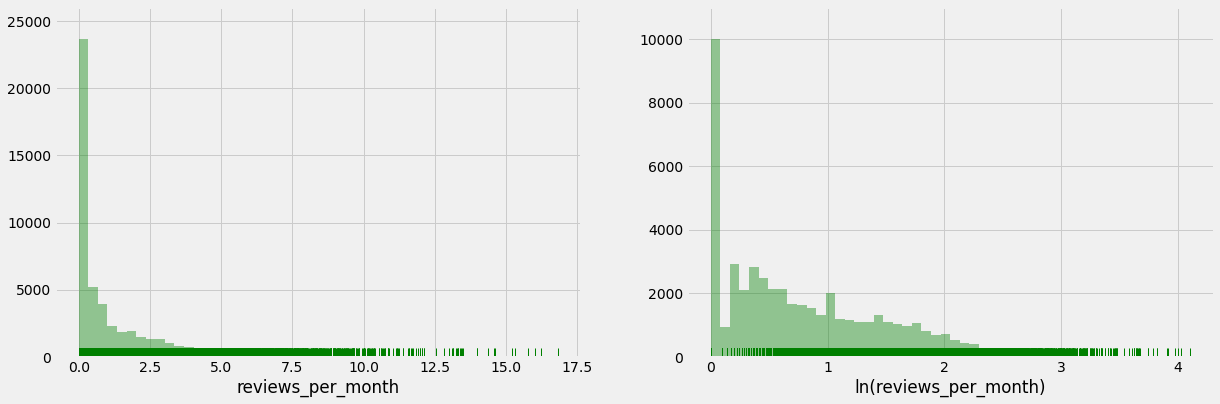

In [31]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))
sns.distplot(data[data['reviews_per_month'] < 17.5]['reviews_per_month'], rug=True, kde=False, color="green", ax=axes[0])
sns.distplot(np.sqrt(data[data['reviews_per_month'] < 17.5]['reviews_per_month']), rug=True, kde=False, color="green", ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)')

The distribution of the number of reviews per month is highly skewed however way we cut it. This is because there is a large weight on smaller number of reviews: there are a lot of properties which only get a few reviews and a rather fat tail of properties which get a lot of reviews. 

One explanation would be that the properties which are available a larger fraction of the year get more reviews. However, a scatter plot of reviews_per_month and availability_365 variables shows no evidence of a relationship so that explanation would appear to not be valid.

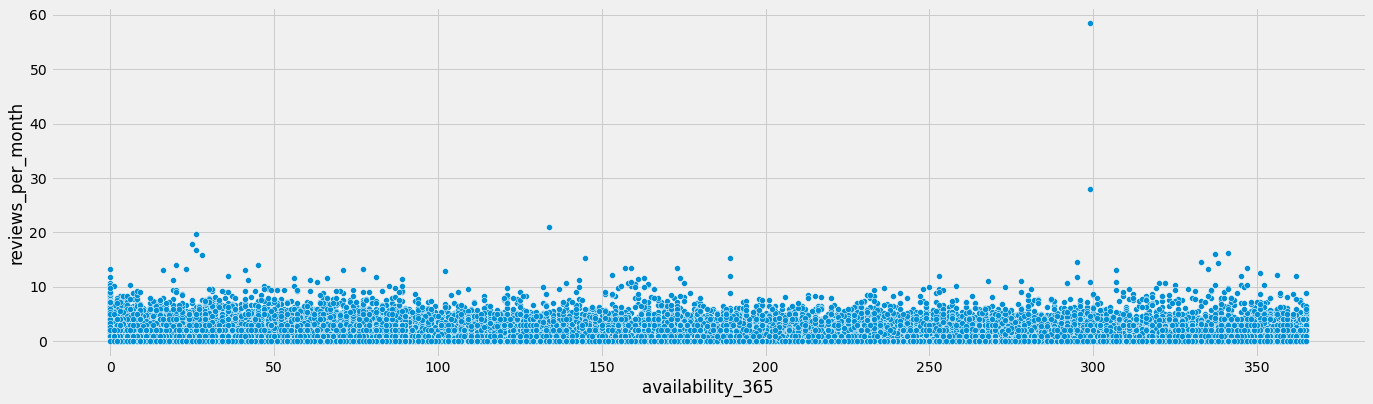

In [32]:
fig, axes = plt.subplots(1,1, figsize=(21,6))
sns.scatterplot(x= data['availability_365'], y=data['reviews_per_month'])

In [33]:
data['reviews_per_month'] = data[data['reviews_per_month'] < 17.5]['reviews_per_month']

8. Availability

(0.0, 365.0)

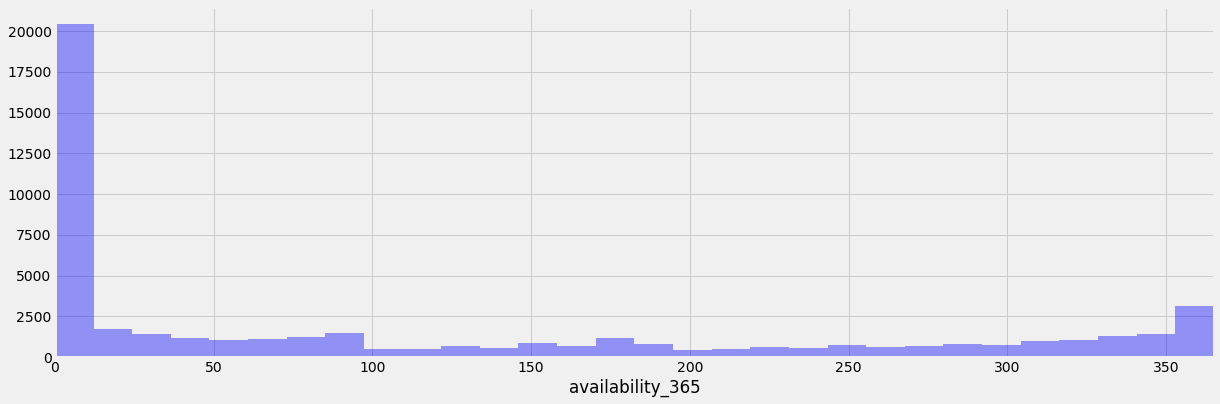

In [34]:
fig, axes = plt.subplots(1,1,figsize=(18.5, 6))
sns.distplot(data['availability_365'], rug=False, kde=False, color="blue", ax=axes)
axes.set_xlabel('availability_365')
axes.set_xlim(0, 365)

9. Feature Engineering

In [35]:
data['all_year_avail'] = data['availability_365']>353
data['low_avail'] = data['availability_365']< 12
data['no_reviews'] = data['reviews_per_month']==0

10. Pearson correlation

Text(0.5, 1.0, 'Correlation Matrix')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


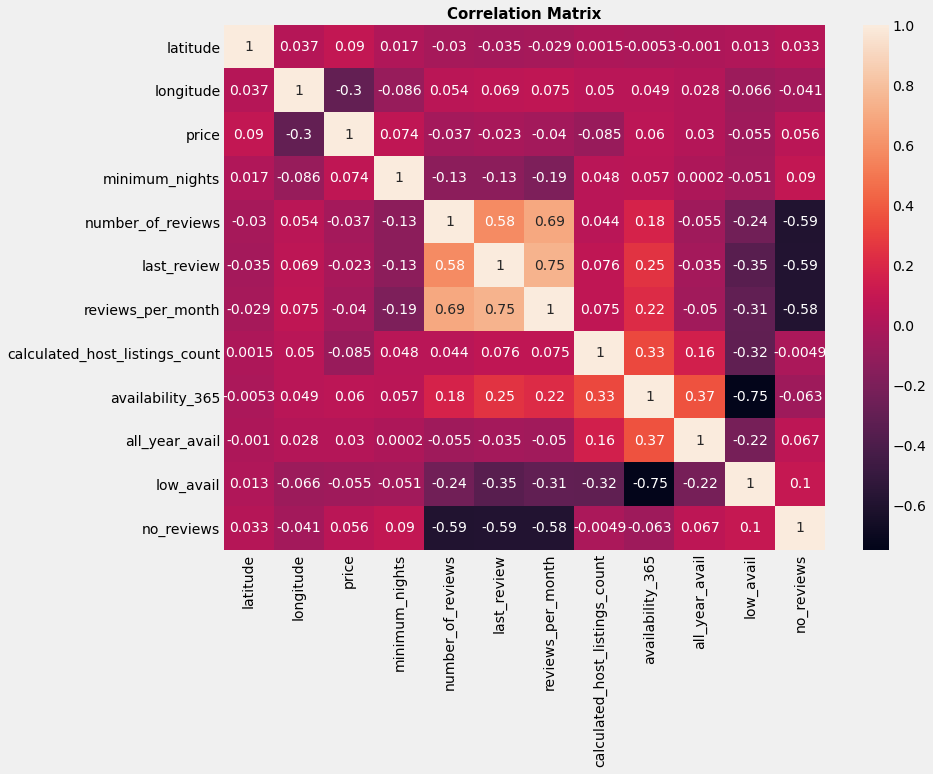

In [36]:
#plotting the pearson correlation plot to visualise the correlation between various features

corrmatrix = data.corr(method = 'kendall')
plt.subplots(figsize=(12,9))
sns.heatmap(corrmatrix, annot=True)
plt.title("Correlation Matrix",size=15, weight='bold')


There don't appear to exist obvious, strong correlations between these variables.

However, the number of reviews per month is fairly (40%) correlated with the total number of reviews and the the total number of reviews is correlated (at 30%) with the availability of the property. Both of these correlations make sense.

It's also interesting that the longitude is anticorrelated (at 20%) with the price. That also makes sense - property in the Bronx and in Queens is cheaper than Manhattan and Brooklyn.




<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



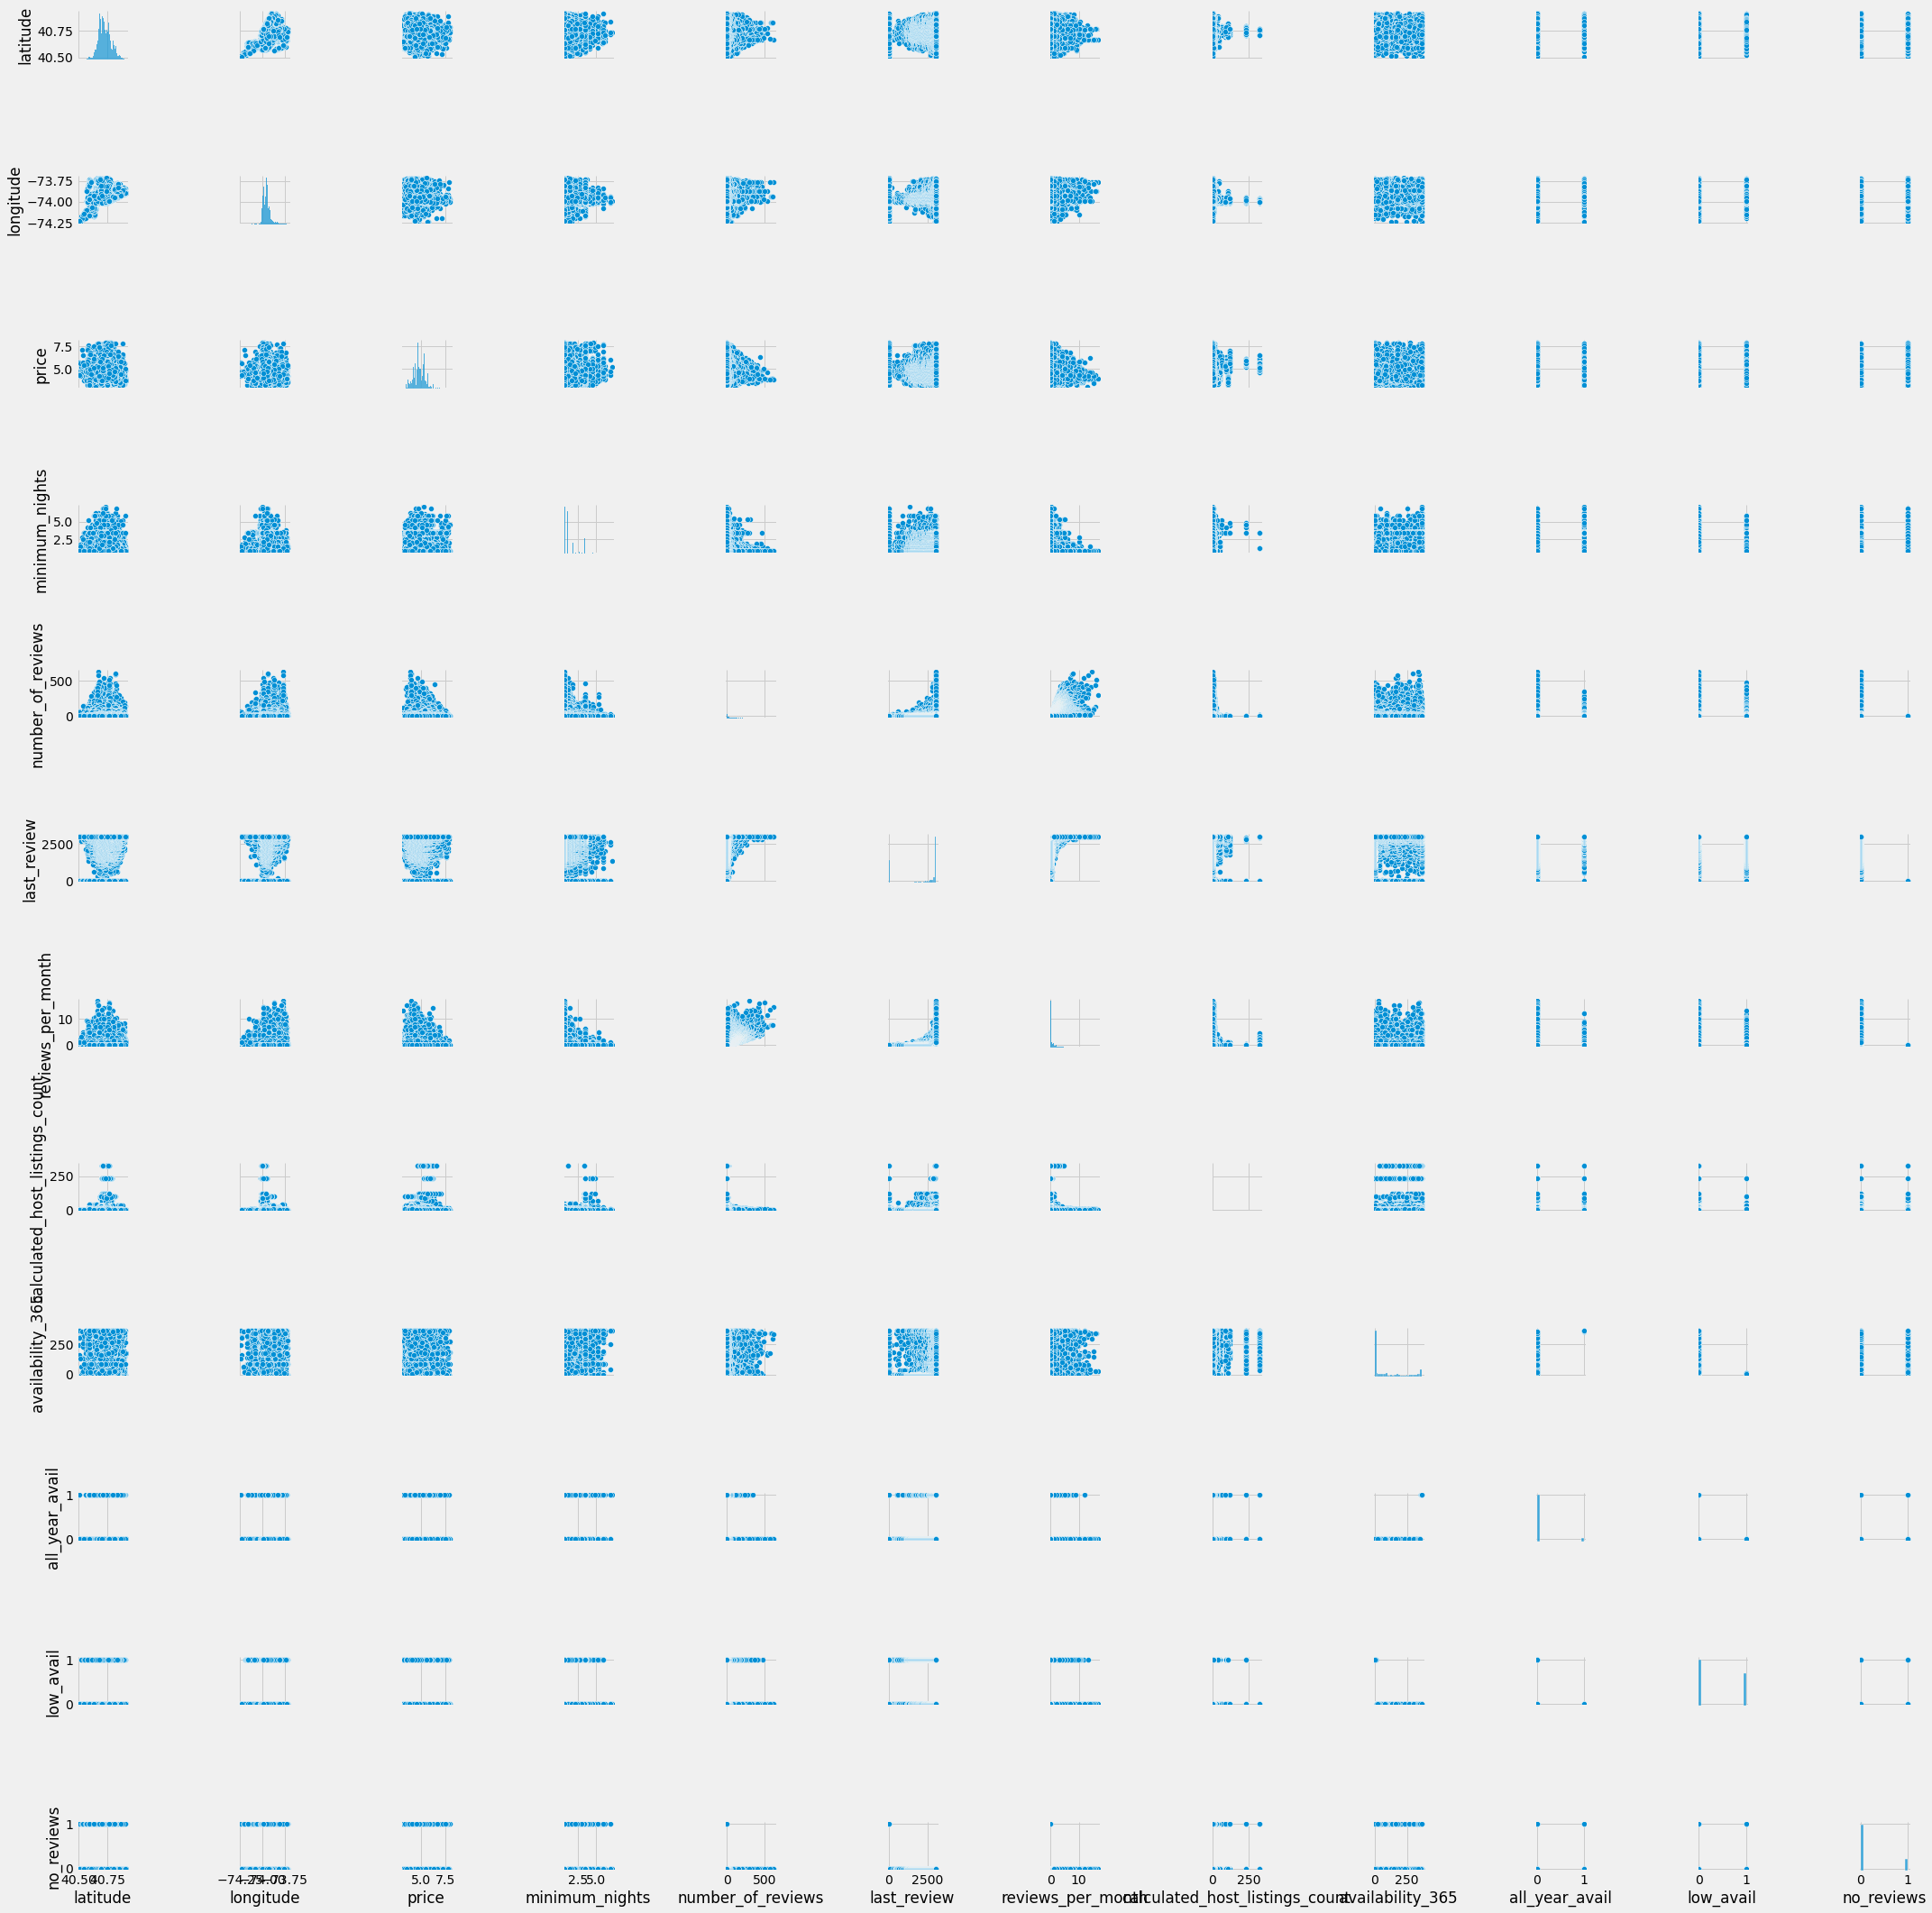

In [37]:
#pair plot
sns.pairplot(data.select_dtypes(exclude=['object']))

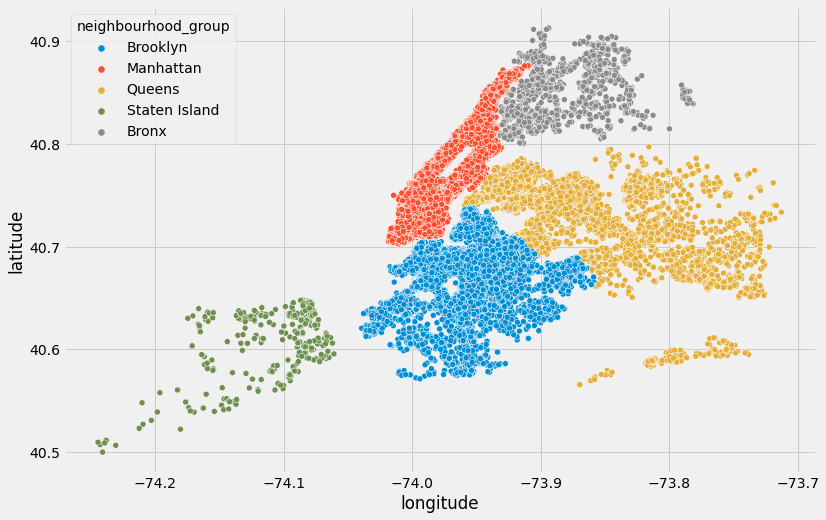

In [38]:
#scatter plot to show cluster location by neighborhood group
plt.figure(figsize=(12,8))
sns.scatterplot(x=data.longitude,y=data.latitude,hue=data.neighbourhood_group)
plt.show()

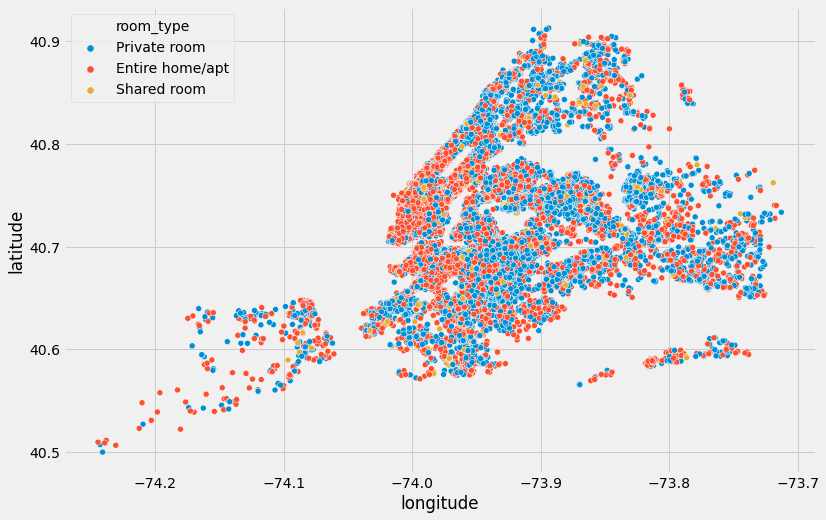

In [39]:
#cluster location by room type

plt.figure(figsize=(12,8))
sns.scatterplot(data.longitude,data.latitude,hue=data.room_type)
plt.show()

11. Encoding Categorical Features

In [40]:
categorical_features = data.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (48784, 3)


In [41]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,neighbourhood_Cambria Heights,neighbourhood_Canarsie,neighbourhood_Carroll Gardens,neighbourhood_Castle Hill,neighbourhood_Castleton Corners,neighbourhood_Chelsea,...,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Stuyvesant Town,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Throgs Neck,neighbourhood_Todt Hill,neighbourhood_Tompkinsville,neighbourhood_Tottenville,neighbourhood_Tremont,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_Unionport,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Van Nest,neighbourhood_Vinegar Hill,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Brighton,neighbourhood_West Farms,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [42]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [43]:
#analyze numerical features

numerical_features =  data.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))

Numerical features: (48784, 11)


In [44]:
#concatenate the encoded features with the numerical features

X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)
#print('Dimensions of the design matrix: {}'.format(X.shape))
#print('Dimension of the target vector: {}'.format(y.shape))

In [45]:
processed_data = pd.concat([X_df, y], axis = 1)
processed_data.to_csv('NYC_Airbnb_processed.dat')

# Test - Train Split


I'm going to split the data into a test set and a training set. I will hold out the test set until the very end and use the error on those data as an unbiased estimate of how my models did.

The test size is 20% and train size is 80% of the preprocessed and cleaned data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (39027, 240)
Dimensions of the training target vector: (39027,)
Dimensions of the test feature matrix: (9757, 240)
Dimensions of the test target vector: (9757,)


Rescale the design matrix

* I now scale the design matrix with sklearn's RobustScaler() so that each predictor has zero mean and unit variance. This helps the convergence of machine learning algorithms such as linear regression.

* It will scale features using statistics that are robust to outliers.

* This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

* Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method.

* Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.



In [48]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


# Linear Regression and Ridge Linear Regression

Since our target variable, the rental price, is a continuous variable, we consider this problem as a supervised regression problem instead of classification. Thus, the baseline model is the default linear regression.

In [49]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train,y_train)
pred_lr= reg.predict(X_test)

However, linear regression is always too oversimplified for reality problem because it assumes the covariates and response variables to have linear relationship which may not suit our problem. To improve this, we also use another linear model , the Ridge Regression Model with sklearn.linear_model.Ridge. This solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. To find the optimal parameters and avoid overfitting, we also compare the performance of model with alphas=[0.001,0.01,0.1,1] as well as cross validation by RidgeCV.

In [50]:
from sklearn.linear_model import RidgeCV

# To avoid overfit we use cross validation
ridge_cv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train,y_train)
pred_ridge=ridge_cv.predict(X_test)

# Random Forest

Random forest is also a common ensemble learning method for regression. It runs decision trees in parallel which means there is no interaction between these trees while building the trees. Different kinds of models have different advantages. The random forest model is very good at handling tabular data with numerical features, or categorical features with fewer than hundreds of categories. Unlike linear models, random forests are able to capture non-linear interaction between the features and the target. Since the linear model above did not perform well, we guess there should be a nonlinear relationship between target variable and features which means nonlinear model like random forest may predict well.One important note is that because the result of decision trees will vary a lot as the parameters change a little, it is important to try different combinations of parameters in order to find the best fitted model.

In [51]:
from sklearn.ensemble import RandomForestRegressor
# random forest regressor
def random_forest_model(X_train, y_train, X_test, y_test):
    best_test_score = 0 
    best_train_score = 0
    best_depth = 0
    # tune for tree depth from 1 to 20
    for j in range(1, 21):
        rf = RandomForestRegressor(n_estimators=50, max_depth=j, oob_score=True)
        rf.fit(X_train, y_train)
        score_train = rf.score(X_train, y_train)
        score = rf.score(X_test, y_test)
        if score > best_test_score:
            best_test_score = score
            best_train_score = score_train
            best_depth = j
    return best_train_score, best_test_score, best_depth

Because the result of decision trees will vary a lot as the parameters change a little, it is important to try different combinations of parameters in order to find the best fitted model.

In [52]:
rf_values = random_forest_model(X_train, y_train, X_test, y_test)
print ('Train Score with Best Test:', rf_values[0])
print ('Best Test Score:', rf_values[1])
print ('Best Depth', rf_values[2])
rf = RandomForestRegressor(n_estimators=50, max_depth=rf_values[2], oob_score=True)
rf.fit(X_train, y_train)
pred_rf= rf.predict(X_test)

Train Score with Best Test: 0.7694875841148833
Best Test Score: 0.604920076412408
Best Depth 13


In [80]:
#print(rf.estimators_)

In [81]:
import eli5

In [83]:
#analyzing weights for each feature using eli5

eli5.show_weights(rf, feature_names=list(X_df.columns))

Weight,Feature
0.5213 ± 0.0113,room_type_Entire home/apt
0.1009 ± 0.0238,longitude
0.1000 ± 0.0088,latitude
0.0512 ± 0.0048,availability_365
0.0481 ± 0.0200,neighbourhood_group_Manhattan
0.0372 ± 0.0038,minimum_nights
0.0244 ± 0.0038,calculated_host_listings_count
0.0224 ± 0.0052,last_review
0.0207 ± 0.0044,number_of_reviews
0.0190 ± 0.0047,reviews_per_month


In [53]:
rf2 = RandomForestRegressor(random_state=42)
from pprint import pprint
print('Parameters currently in use: \n')
pprint(rf.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 13,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [54]:
#Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop=2000,num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [55]:
rf_random = RandomizedSearchCV(estimator=rf2, param_distributions = random_grid, n_iter=10, cv = 3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 117.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [56]:
#best_random = rf_random.best_estimator_

In [57]:
#fitting the best parameters obtained from RandomizedSearchCV

best_random = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)

In [59]:
orig_data = pd.read_csv('AB_NYC_2019.csv/AB_NYC_2019.csv')

In [67]:
#predict price and add it to a dataframe and save it to a csv
predicted = best_random.predict(X)

In [64]:
#predict = model.predict(X)
predict = pd.DataFrame(predicted, columns=['predicted_price'])
df_submit = pd.concat([orig_data['id'],predict], axis=1)
df_submit.to_csv('NY_airbnb_predicted_price.csv')

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
*min_samples_leaf = min number of data points allowed in a leaf node
*bootstrap = method for sampling data points (with or without replacement)

# Linear SVR

Another common approach is Support Vector Regression. The SVR uses the same principles as the SVM for classification: to minimize error, individualizing the hyperplane that maximizes the margin. However, the implementation of sklearn.SVR is based on libsvm. The fit time complexity is more than quadratic with the number of samples, which makes it hard to scale to datasets with more than a couple of 10000 samples. So instead, we use skearn.LinearSVR. It is similar to SVR with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples. The non-linear SVR model may give a better result, but in this project, we only model the linear SVR considering computational efficiency.

In [69]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(LinearSVR(max_iter=1000),{'C':[0.01,0.1,1,10]}, cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)
grid_search.best_params_

Liblinear failed to converge, increase the number of iterations.


{'C': 0.01}

We use GridSearchCV to do model tuning to find the optimal C value that gives best prediction and cross validation with fold 5 to avoid overfitting.



In [ ]:
regr = LinearSVR(C=0.01)
regr.fit(X_train,y_train)
pred_regr=regr.predict(X_test)

# KNN

The last way to approach is by the k-nearest neighbors algorithm. It is a form of memory based learning wherein we don’t learn a function of features to estimate the target variable. It searches the training data for the k nearest neighbors, as calculated by Euclidean distance function, then does the regression process based on the value of these k neighbors. To find the optimal value of k, we compared the performance of knn models with k in the range of (5,25).

In [72]:
#Multi-Variate KNN Model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

#Method to find the optimal amount of neighbors
def findoptK(k_list):
    opt_k=0
    opt_rmse=100000
    for k in k_list:
        knn= KNeighborsRegressor(n_neighbors=k,algorithm='brute')
        knn.fit(X_train, y_train)
        knn_pred = knn.predict(X_test)
        if mean_squared_error(y_test, knn_pred)**(1/2)< opt_rmse:
            opt_rmse=mean_squared_error(y_test, knn_pred)**(1/2)
            opt_k=k
    return opt_k

In [73]:
k_list=range(5,25)
knn= KNeighborsRegressor(n_neighbors=findoptK(k_list),algorithm='brute')
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)

# Evaluation metrics

To evaluate regression models, R-squared is the most commonly used. It is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression. R-squared is the percentage of the response variable variation that is explained by a linear model as R-squared = Explained variation / Total variation. 0% indicates that the model explains none of the variability of the response data around its mean. While 100% indicates that the model explains all the variability of the response data around its mean. In general, the higher the R-squared, the better the model fits your data. However, there are important conditions for this guideline that I’ll talk about both in this post and my next post.

We also used Root Mean Square Error(RMSE) and Median Absolute Error(MAE) to evaluate the models. RMSE is simply the root of mean squred error. We used Median Absolute Error becuase it is less sensitive to outliers than Mean Squared Error and translates nicely to a dollar amount that is relative to price.

In [94]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

#A dictionary to store evaluation data
Eva_data={'RMSE':[], 'MAE':[], 'R2_testing':[]}

In [95]:
pred_list=[pred_lr,pred_ridge,y_test_rfr,pred_regr,pred_knn]

for pred in pred_list:
  Eva_data['RMSE'].append(mean_squared_error(y_test, pred)**(1/2))
  Eva_data['MAE'].append(median_absolute_error(y_test, pred))
  Eva_data['R2_testing'].append(r2_score(y_test,pred))

In [96]:
eva_df=pd.DataFrame(Eva_data,index=['Linear Regression','Ridge Regression','Random Forest','Linear SVR','KNN'])
eva_df

,RMSE,MAE,R2_testing
Linear Regression,0.442617,0.247621,0.571542
Ridge Regression,0.442182,0.246803,0.572385
Random Forest,0.419931,0.231119,0.614337
Linear SVR,0.449716,0.238843,0.557688
KNN,0.442326,0.249945,0.572106


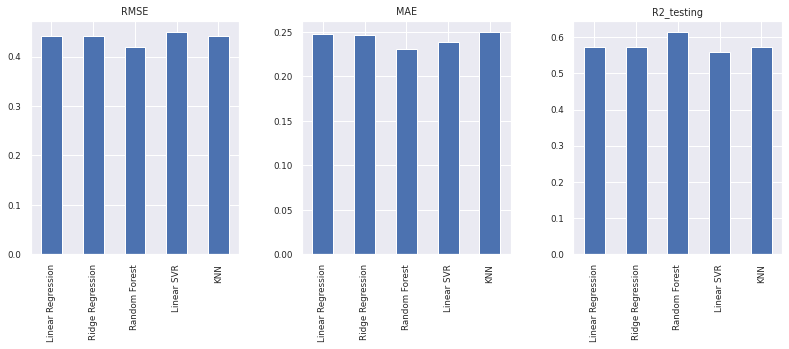

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (12,4))
plt.subplots_adjust(wspace=0.3)

for i in range(len(eva_df.columns)):
  eva=eva_df.columns[i]
  eva_df[eva].plot(kind='bar', ax=axes[i], title=eva)

From the above histograms, we can see that after implementation, the test data accuracy of Linear Regression turns out to be really low, so clearly linear regression is too oversimplified for our problem. Also, the Ridge Regression perform similarly to Linear Regression with a little bit differences in RMSE and MAE which means it also does not improve the result a lot. Because we have a relatively large amount of data, the probability of over-fitting seem to be low. We also do the R2-score in training set and confirm that each R2-score is always between 40% and 70% which means these models do not have a too high R2 as not true.

We can see that Random Forest, Linear SVR and KNN models perform both have their advantages and weaknesses. Random Forest has the lowest RMSE and MAE. However, as the models’ RMSE and MAE do not vary a lot, we can use R2 score in testing dataset to determine which model perform better. As Random Forest model has the highest R2 score , we can conclude that it is the best-performance model. This is understandable since the reality relationship seem to be nonlinear. In general, our best model Random Forest explains the variation in the target variable around its mean for any given test dataset.

Overall, we see that ensemble methods are promising, but require a considerable amount of computational time as well to tune for the best parameters. With further and more comprehensive tuning, it is very likely that the Median Absolute Error could be decreased for an ensemble method.

# Strengths and Weaknesses of The Proposed Methodology


Random forest model reduces the probability of overfitting by averaging the prediction results of a diverse set of trees. It is always compared with the decision tree - the total bias of random forest is higher, as it trains independent trees on random samples of data. However, the final prediction result is the average of all individual trees, which alleviate the increased bias by reducing variance. Therefore, the accuracy of the random forest is always slightly higher than the decision tree.

KNN model is non-parametric, which means it does not make an assumption about the underlying data distribution pattern, and this reduces the bias due to the model selection compared to parametric methods. However, this model can be problematic since we have a group of features. The high dimensionality data not only prolong the computation time, but also lower the accuracy of KNN. Also, this model is very sensitive to outliers.

# Improvements and Limitations

The results are fairly well because the price depends on various factors that are far more than the response variables we used, but it is not good-enough since the best model only explain 61% of the variance in given test dataset. There are some more can be added as response variables such as the number of rooms, number of bathrooms, number of subway lines in 300m, pet-friendly or not, etc. Also, as from some predictions, we conclude the regression to be linear, we can try more polynomial regression models that may fit the problem better and may get more accurate results.

# Conclusion

This project using different models including Linear Regression, Ridge Regression, Linear SVR, Random Forest, and KNN to predict prices for airbnb in NYC. Through comparing RMSE, MAE, and R2-score in testing dataset, we conclude that Random Forest outperforms others. 

References:

https://www.datasciencecentral.com/profiles/blogs/regression-analysis-how-do-i-interpret-r-squared-and-assess-the

https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d

https://medium.com/@rtabibi98/using-machine-learning-to-predict-airbnb-listing-prices-in-new-york-city-2a5f2c8d1b03


Copyright 2020 Gauri Verma

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.